# Model Run
Version 1: original

## Import Libs

In [12]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, random_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from model_model import JudgeNetwork
from model_configs import ModelDimConfigs, TrainingConfigs
from misc_tools import get_timestamp
from model_dataset import MelSpecTransform, DS_Tools
from model_dataset import SingleRecDataset as ThisDataset
from paths import *

## Configure READ

In [2]:
READ = False

## Get Timestamp

In [3]:
if READ: 
    ts = ""
else: 
    ts = str(get_timestamp())

train_name = "judge"
model_save_dir = os.path.join(model_save_, f"{train_name}-{ts}")
mk(model_save_dir)

## Prepare Dataset

In [4]:
mytrans = MelSpecTransform(sample_rate=TrainingConfigs.REC_SAMPLE_RATE, 
                            n_fft=TrainingConfigs.N_FFT, 
                            n_mels=TrainingConfigs.N_MELS)
ds = ThisDataset(train_cut_audio_, os.path.join(src_, "guide_mod.csv"), transform=mytrans)

if not READ: 
    use_len = int(0.01 * len(ds))
    remain_len = len(ds) - use_len
    use_ds, remain_ds = random_split(ds, [use_len, remain_len])

    train_len = int(0.8 * len(use_ds))
    valid_len = len(use_ds) - train_len

    # Randomly split the dataset into train and validation sets
    train_ds, valid_ds = random_split(use_ds, [train_len, valid_len])

    # NOTE: we don't need to save the cut-small subset, because after cutting-small, 
    # the saved train and valid separations will reflect this
    DS_Tools.save_indices(os.path.join(model_save_dir, "train.data"), train_ds.indices)
    DS_Tools.save_indices(os.path.join(model_save_dir, "valid.data"), valid_ds.indices)
else: 
    train_ds_indices = DS_Tools.read_indices(os.path.join(model_save_dir, "train.data"))
    valid_ds_indices = DS_Tools.read_indices(os.path.join(model_save_dir, "valid.data"))

    train_ds = torch.utils.data.Subset(ds, train_ds_indices)
    valid_ds = torch.utils.data.Subset(ds, valid_ds_indices)

train_loader = DataLoader(train_ds, batch_size=TrainingConfigs.BATCH_SIZE, 
                          shuffle=True, 
                          num_workers=TrainingConfigs.LOADER_WORKER, 
                          collate_fn=ThisDataset.collate_fn)
train_num = len(train_loader.dataset)

valid_loader = DataLoader(valid_ds, batch_size=TrainingConfigs.BATCH_SIZE, 
                          shuffle=False, 
                          num_workers=TrainingConfigs.LOADER_WORKER, 
                          collate_fn=ThisDataset.collate_fn)
valid_num = len(valid_loader.dataset)

In [8]:
np.unique(ds.seg_set).shape

(39,)

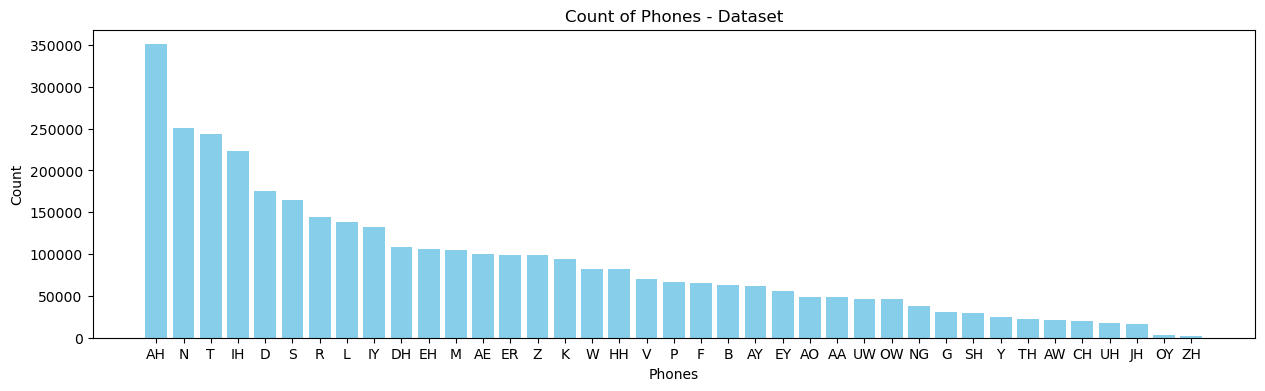

In [30]:
# data = {'type': ds.seg_set}
# counts = pd.DataFrame(data)["type"].value_counts()
# # Create a bar graph for vowels
# plt.figure(figsize=(15, 4))
# plt.bar(counts.index, counts.values, color='skyblue')
# plt.xlabel('Phones')
# plt.ylabel('Count')
# plt.title('Count of Phones - Dataset')
# plt.xticks(rotation=0)  # Rotate x-axis labels if needed

# # Display the bar graph
# plt.show()


# data = {'type': ds.seg_set}
# counts = pd.DataFrame(data)["type"][train_ds.indices].value_counts()
# # Create a bar graph for vowels
# plt.figure(figsize=(15, 4))
# plt.bar(counts.index, counts.values, color='skyblue')
# plt.xlabel('Phones')
# plt.ylabel('Count')
# plt.title('Count of Phones - Trainset')
# plt.xticks(rotation=0)  # Rotate x-axis labels if needed

# # Display the bar graph
# plt.show()


# data = {'type': ds.seg_set}
# counts = pd.DataFrame(data)["type"][valid_ds.indices].value_counts()
# # Create a bar graph for vowels
# plt.figure(figsize=(15, 4))
# plt.bar(counts.index, counts.values, color='skyblue')
# plt.xlabel('Phones')
# plt.ylabel('Count')
# plt.title('Count of Phones - Validset')
# plt.xticks(rotation=0)  # Rotate x-axis labels if needed

# # Display the bar graph
# plt.show()

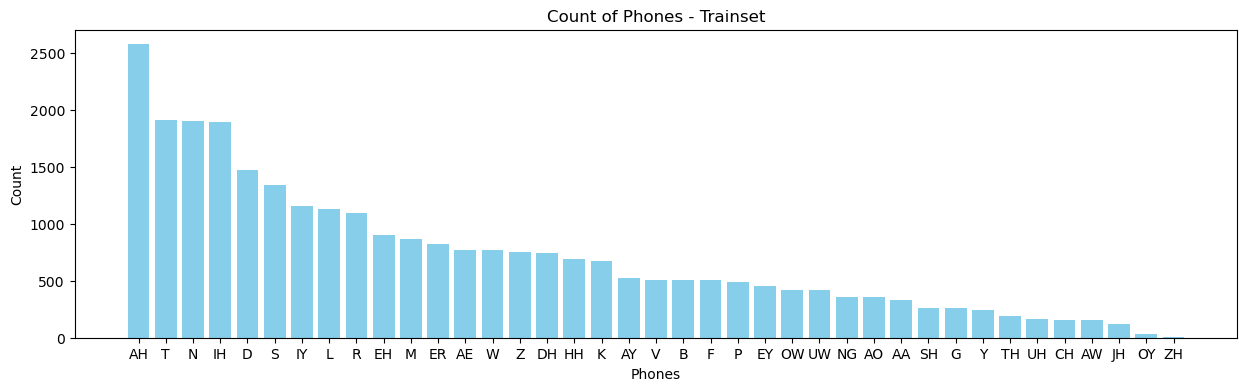

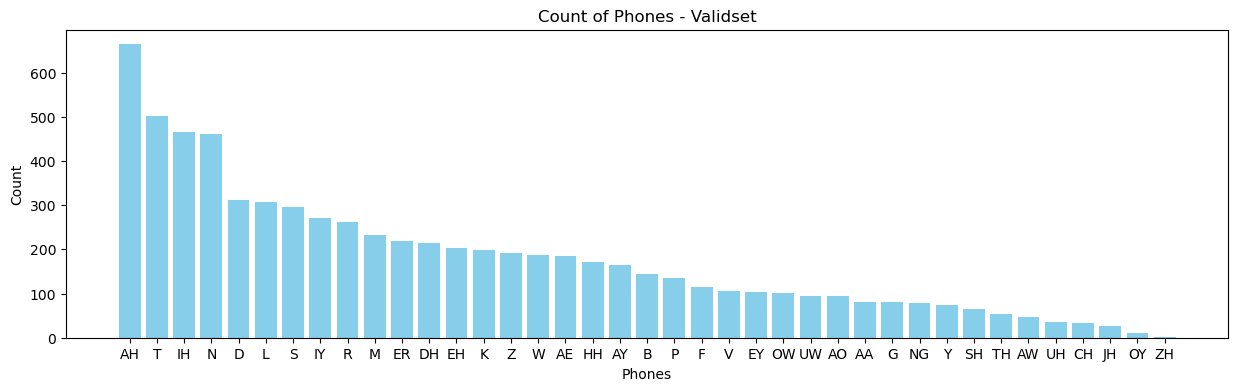

## Init Model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
# NOTE: no need to mask the loss, because we don't do reconstruction. 

dimconf = ModelDimConfigs(
        rnn_in_size=64, 
        lin_in_size_1=128, 
        lin_in_size_2=64, 
        lin_out_size_2=39
    )

model = JudgeNetwork(
    dimconf=dimconf
)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)